# Gaussian impurity sweeps

In [1]:
import kwant
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from amsc import (
    bulk_amsc_system,
    generate_intial_Delta,
    setup_gaussian_impurities,
)
from plot_tools import add_tl_label
from tqdm.notebook import tqdm
from pauli import *
from qm_tools import sparse_diag, sort_eigensystem

In [2]:
# eigsh = sla.eigsh
eigsh = sparse_diag  # MUMPS

In [3]:
plt.style.use("../plot_style.mplstyle")

## System Setup

In [4]:
periodic_bc = True

Nx = 81
Ny = 81

x_ax = np.linspace(-(Nx // 2), (Nx // 2), Nx)
y_ax = np.linspace(-(Ny // 2), (Ny // 2), Ny)
x, y = np.meshgrid(x_ax, y_ax)

t = 5.0
t_so = 0.0 * t
t_am = 0.25 * t

mu = 2.5
hz0 = 1e-6
hx0 = 0
hy0 = 0

## Initial value for Delta (will be used to determine g)
Delta_init = 1

In [5]:
vortex_positions = []
windings = []
l_core = 0  # l_core is the decay length of the order parameter (in a vortex that is the coherence length)

Delta, theta = generate_intial_Delta(
    x=x,
    y=y,
    Delta_init=Delta_init,
    vortex_positions=vortex_positions,
    windings=windings,
    l_core=l_core,
)

In [6]:
# Impurituy positions
impurity_positions = [(0, 0)]  # , (-10, 0)]
impurity_eccentricities = [0.0]  # Eccentricity
impurity_orientation = [0.0]  # Orientation

hx_imp = [0.0]  # Impurity field
hy_imp = [0.0]  # Impurity field
hz_imp = [0.0]  # Impurity field

In [7]:
N = 80

## Potential

In [8]:
Vss = np.arange(-10, -25.5, -0.5)
P = len(Vss)
wss = np.zeros((P, N))
vss = np.zeros((P, 4 * Nx**2, N), dtype=complex)

for i, Vs in tqdm(enumerate(Vss), total=len(Vss)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=[2.2],
        impurity_positions=impurity_positions,
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=[Vs],
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss[i] = ws
    vss[i] = vs

wss, vss = sort_eigensystem(wss, vss)

  0%|          | 0/31 [00:00<?, ?it/s]

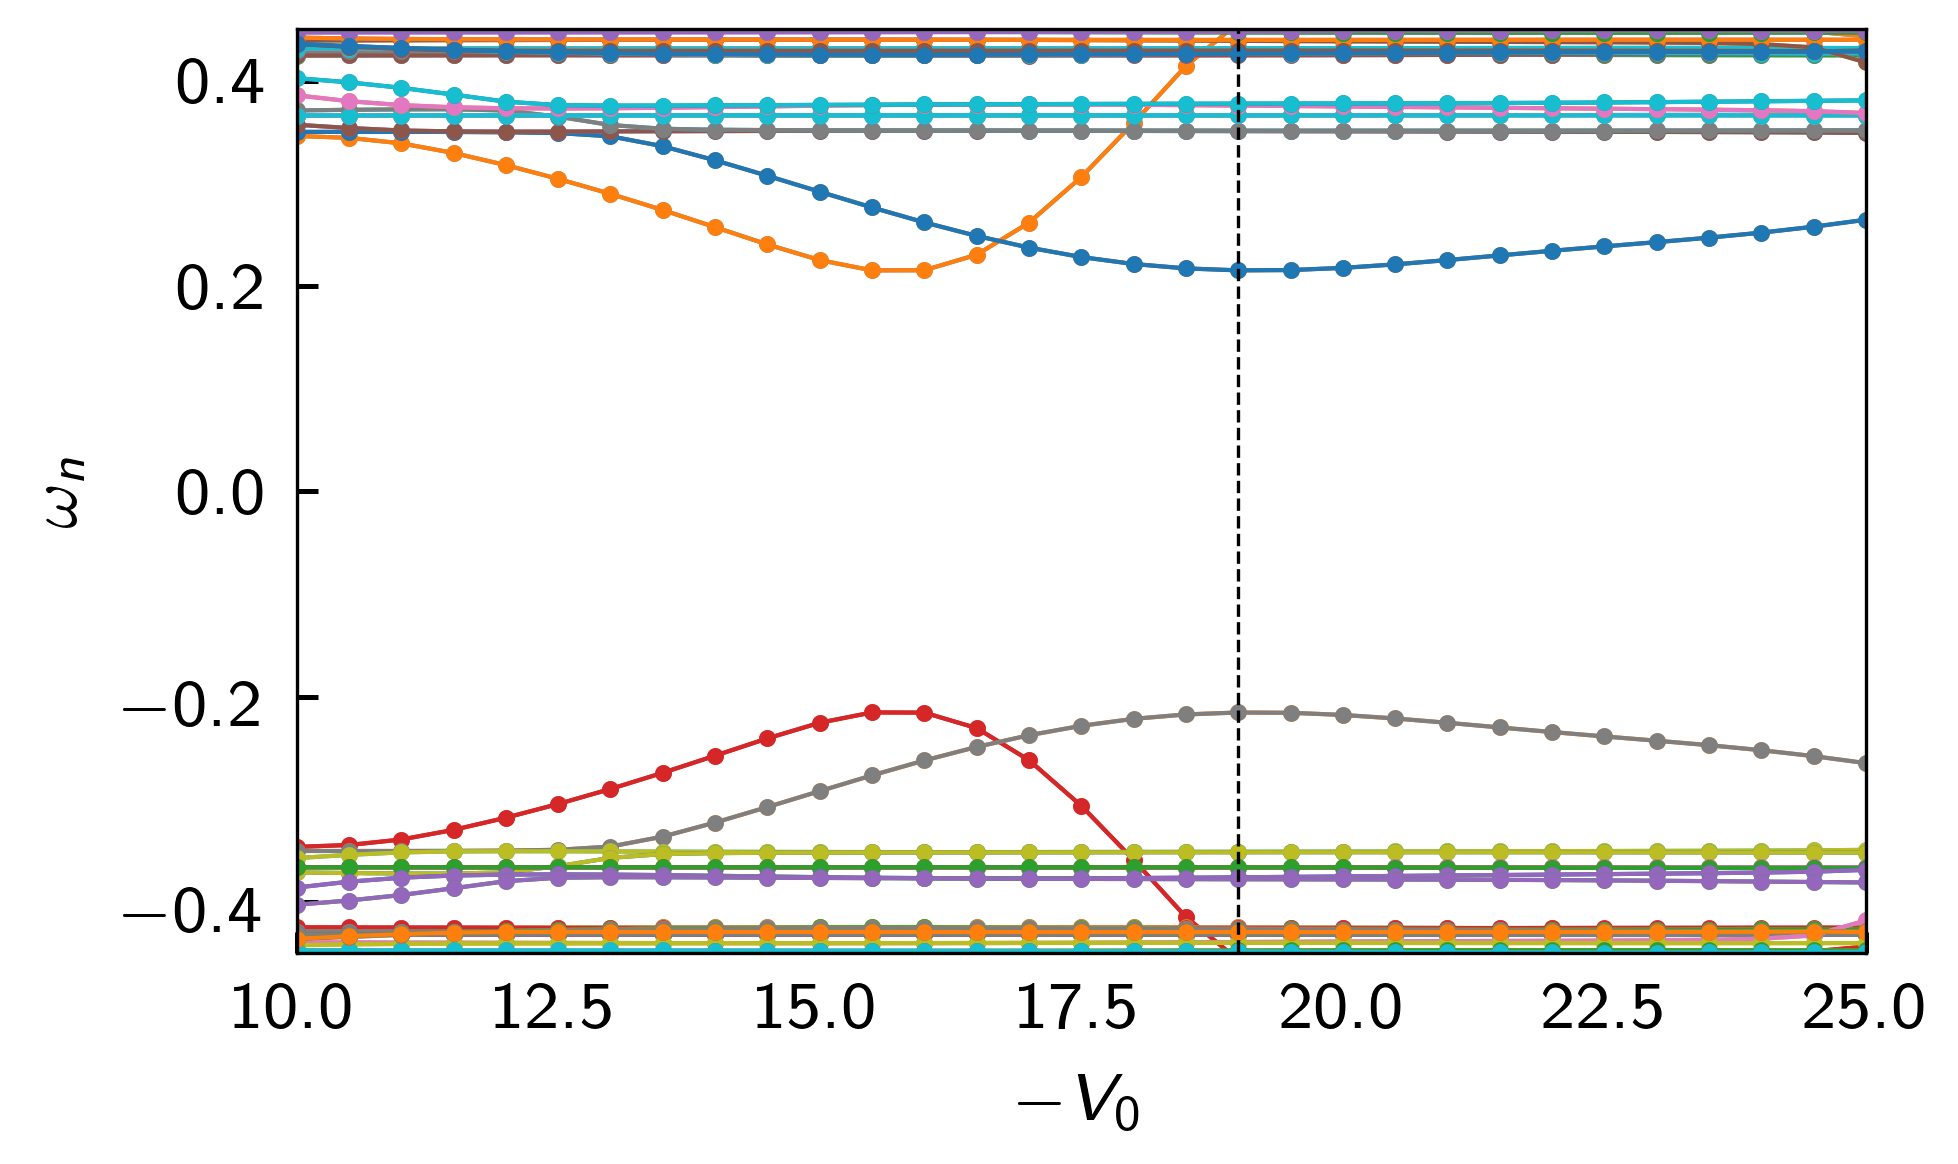

In [16]:
fig, ax = plt.subplots()


ri = np.linspace(0, 1, N)
np.random.shuffle(ri)
linecolors = mpl.cm.tab10(ri)

for i in range(N):
    ax.plot(-Vss, wss[:, i], color=linecolors[i])

ax.set_xlabel(r"$-V_0$")
ax.set_ylabel(r"$\omega_n$")

ax.set_ylim(-0.45, 0.45)
ax.set_xlim(10, 25)

ax.vlines([19], -0.5, 0.5, colors="k", linestyles="dashed", linewidth=0.4)

fig.savefig("./imgs/FigS1b-w22.svg")

In [26]:
idxp = np.argmin(abs(Vss+19.0))
idxs = (abs(wss[idxp])).argsort()

In [27]:
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

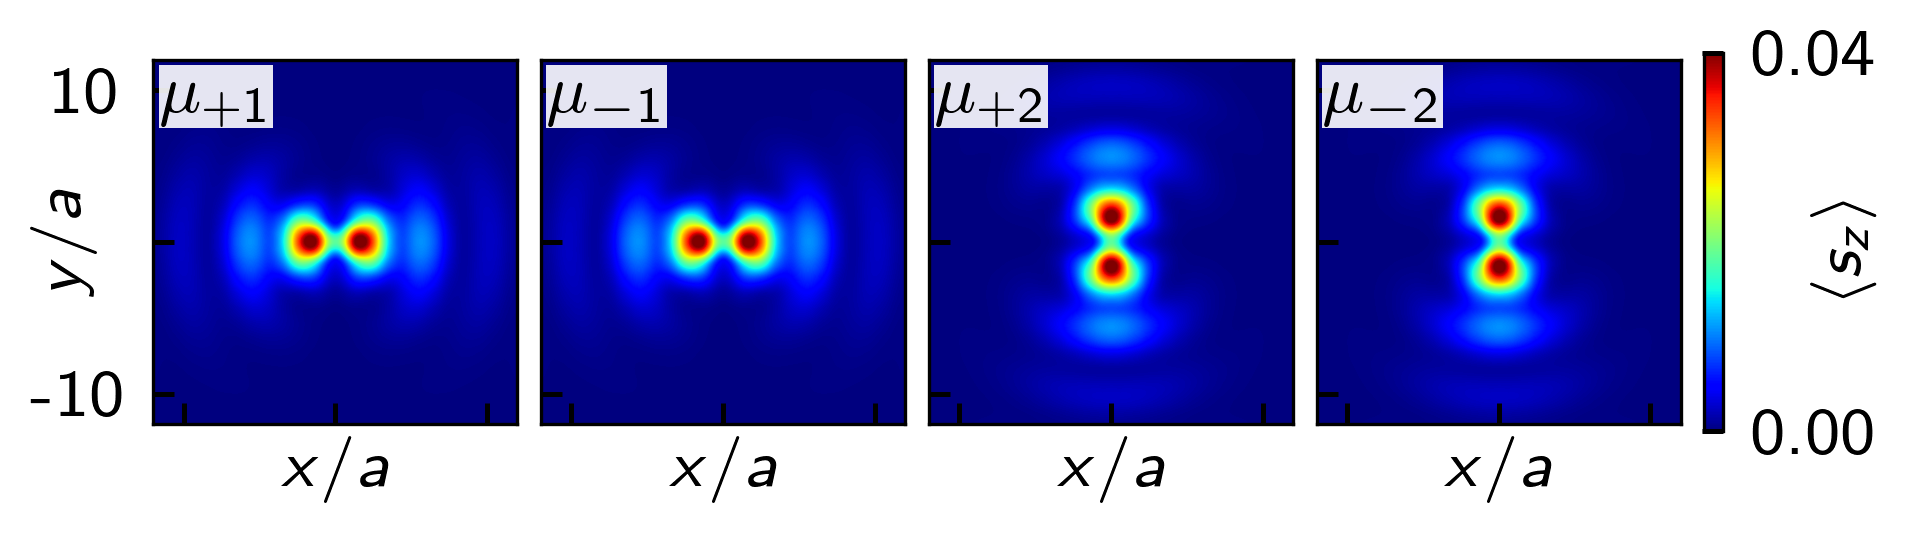

In [28]:
d_1 = t0s0_op(vss[P // 2, :, idxs[0]])
d_2 = t0s0_op(vss[P // 2, :, idxs[1]])
d_3 = t0s0_op(vss[P // 2, :, idxs[2]])
d_4 = t0s0_op(vss[P // 2, :, idxs[3]])

# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 0.82))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)

# Determine color limits
vmax = np.max(np.abs([d_1, d_2, d_3, d_4]))
vmin = 0

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 4])

cmap = "jet"
relwidth = 0.04
im1d = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im2d = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im3d = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im4d = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)

# Set lims
xlims = (-12, 12)
ylims = (-12, 12)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-10, 0, 10], labels=["-10", "", "10"])
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([-10, 0, 10], labels=[])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-10, 0, 10], labels=[])  # labels=["-20", "", "20"])

ax1.set_ylabel(r"$y/a$", labelpad=-8)
ax1.set_xlabel(r"$x/a$", labelpad=-2)
ax2.set_xlabel(r"$x/a$", labelpad=-2)
ax3.set_xlabel(r"$x/a$", labelpad=-2)
ax4.set_xlabel(r"$x/a$", labelpad=-2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)
# Add titles for each subplot
add_tl_label(ax1, r"$\mu_{+1}$")
add_tl_label(ax2, r"$\mu_{-1}$")
add_tl_label(ax3, r"$\mu_{+2}$")
add_tl_label(ax4, r"$\mu_{-2}$")

# Create a common colorbar on the right
# fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap="RdBu_r")
cbar.set_ticks([vmin, vmax], labels=[f"{vmin:.2f}", f"{vmax:.2f}"])
cbar.set_label(r"$\langle s_z \rangle$", labelpad=-8)

# Adjust layout
# gs.tight_layout(fig)#, rect=[0, 0, 0.85, 1])

# Save the figure as SVG with rasterized content

## Size

In [29]:
sizes = np.arange(1.0, 5.1, 0.1)
P = len(sizes)

wss_s = np.zeros((P, N))
vss_s = np.zeros((P, 4 * Nx**2, N), dtype=complex)

for i, size in tqdm(enumerate(sizes), total=len(sizes)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=[size],
        impurity_positions=impurity_positions,
        impurity_eccentricities=impurity_eccentricities,
        impurity_orientations=impurity_orientation,
        V_imp=[-19],
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss_s[i] = ws
    vss_s[i] = vs

wss_s, vss_s = sort_eigensystem(wss_s, vss_s)

  0%|          | 0/41 [00:00<?, ?it/s]

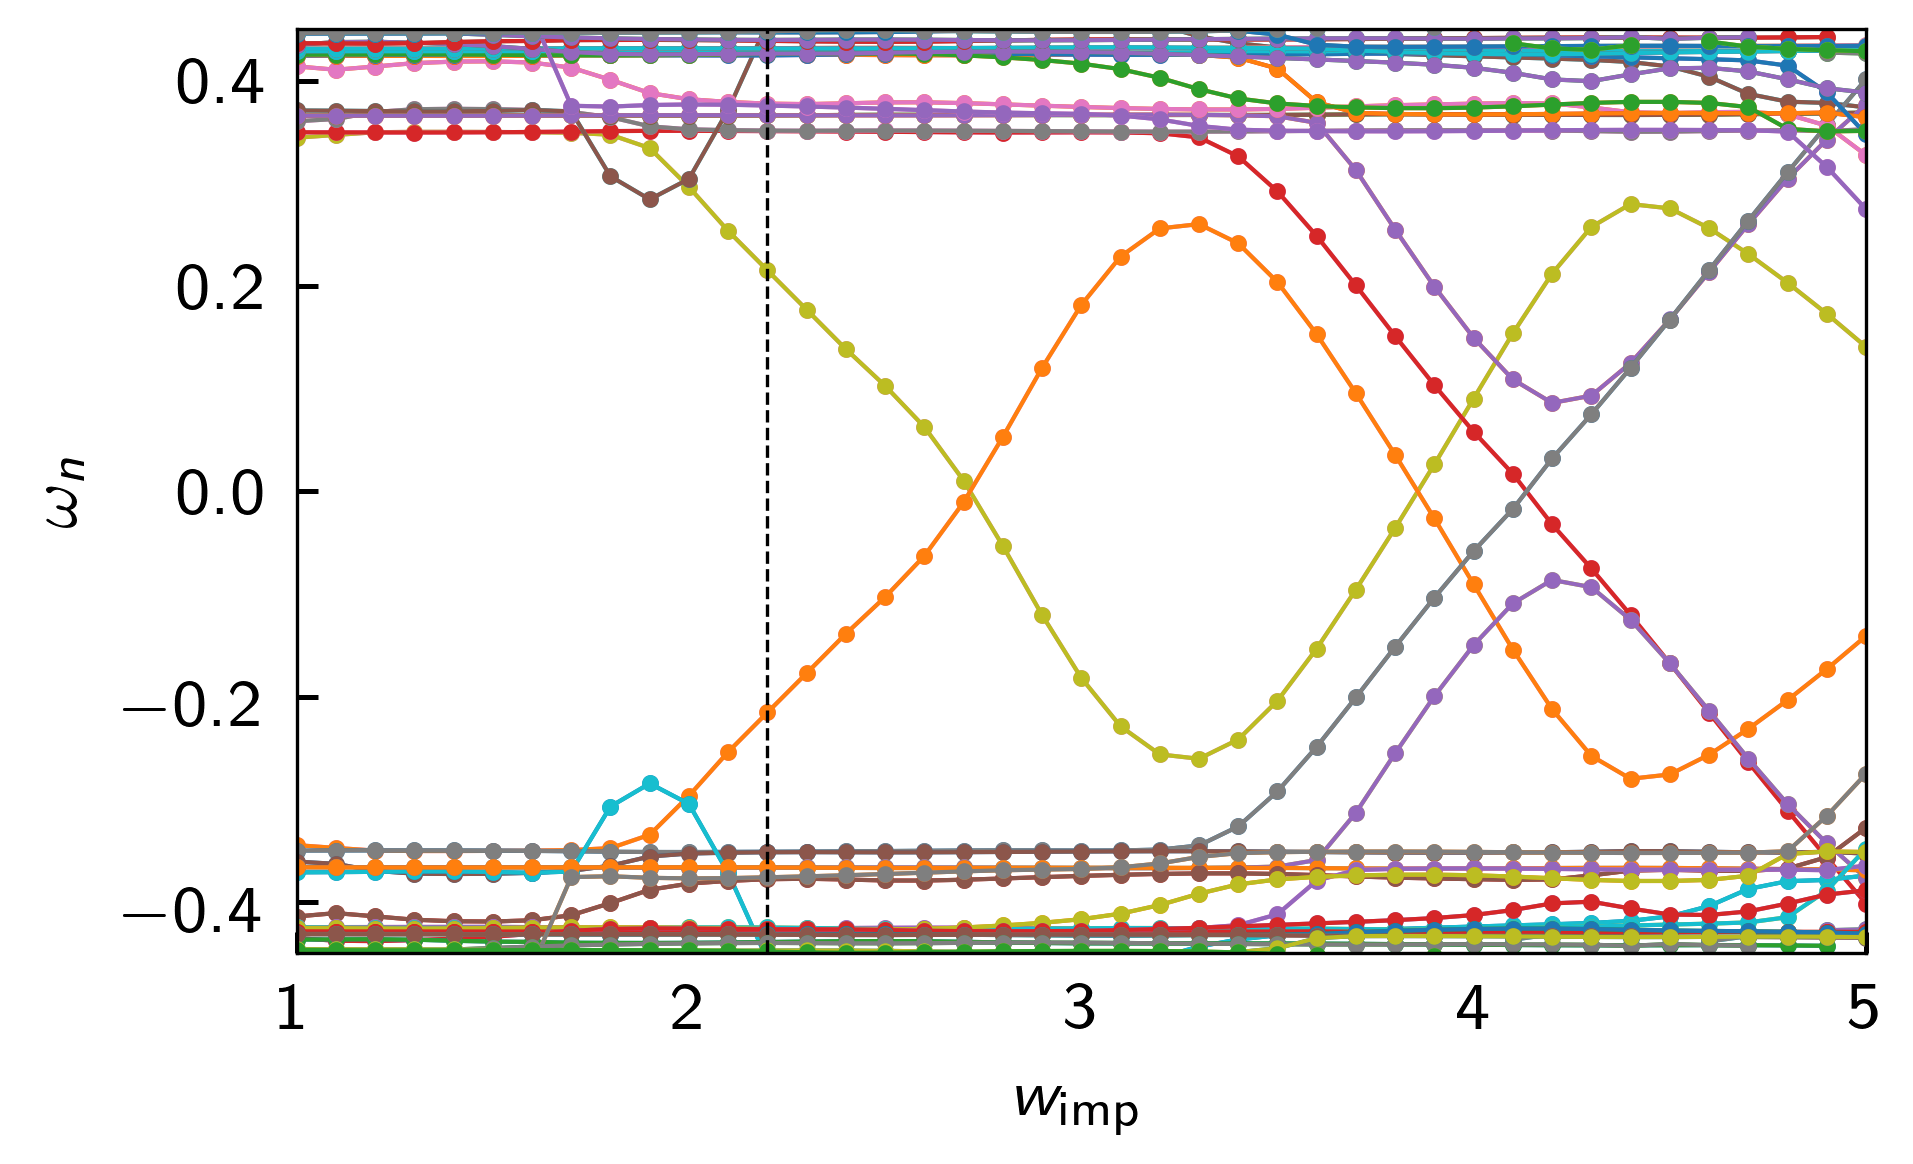

In [30]:
fig, ax = plt.subplots()

ri = np.linspace(0, 1, N)
np.random.shuffle(ri)
linecolors = mpl.cm.tab10(ri)

for i in range(N):
    ax.plot(sizes, wss_s[:, i], color=linecolors[i])

ax.set_xlabel(r"$w_\mathrm{imp}$")
ax.set_ylabel(r"$\omega_n$")

ax.vlines([2.2], -0.5, 0.5, colors="k", linestyles="dashed", linewidth=0.4)
ax.set_ylim(-0.45, 0.45)
ax.set_xlim(1, 5)

fig.savefig("./imgs/FigS1a-V19.svg")

In [31]:
idxp = np.argmin(abs(sizes-2.2))
idxs = (abs(wss_s[idxp])).argsort()

In [32]:
t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)
t0s0_op = kwant.operator.Density(fsyst, onsite=t0s0, sum=False)

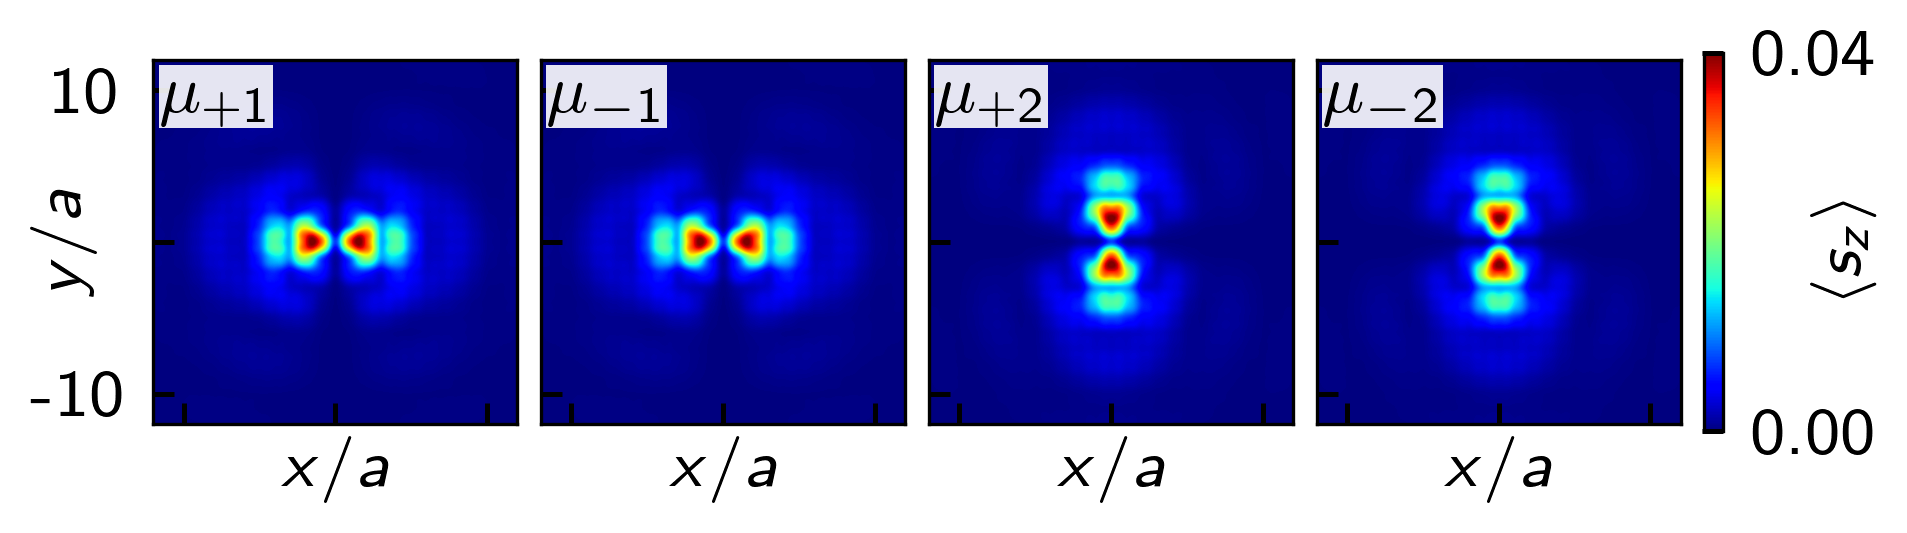

In [33]:
d_1 = t0s0_op(vss_s[P // 2, :, idxs[0]])
d_2 = t0s0_op(vss_s[P // 2, :, idxs[1]])
d_3 = t0s0_op(vss_s[P // 2, :, idxs[2]])
d_4 = t0s0_op(vss_s[P // 2, :, idxs[3]])

# Create figure and gridspace for subplots
fig = plt.figure(figsize=(3.375, 0.82))
gs = fig.add_gridspec(1, 5, width_ratios=[1, 1, 1, 1, 0.05], wspace=0.08, hspace=0.08)

# Determine color limits
vmax = np.max(np.abs([d_1, d_2, d_3, d_4]))
vmin = 0

# Create subplots
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])
cax = fig.add_subplot(gs[0, 4])

cmap = "jet"
relwidth = 0.03
im1d = kwant.plotter.density(fsyst, d_1, ax=ax1, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im2d = kwant.plotter.density(fsyst, d_2, ax=ax2, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im3d = kwant.plotter.density(fsyst, d_3, ax=ax3, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)
im4d = kwant.plotter.density(fsyst, d_4, ax=ax4, cmap=cmap, vmin=vmin, vmax=vmax, relwidth=relwidth)

# Set lims
xlims = (-12, 12)
ylims = (-12, 12)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

# Remove axis labels for inner plots
ax1.set_yticks([-10, 0, 10], labels=["-10", "", "10"])
for ax in [ax2, ax3, ax4]:
    ax.set_yticks([-10, 0, 10], labels=[])

for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([-10, 0, 10], labels=[])  # labels=["-20", "", "20"])

ax1.set_ylabel(r"$y/a$", labelpad=-8)
ax1.set_xlabel(r"$x/a$", labelpad=-2)
ax2.set_xlabel(r"$x/a$", labelpad=-2)
ax3.set_xlabel(r"$x/a$", labelpad=-2)
ax4.set_xlabel(r"$x/a$", labelpad=-2)

# Adjust z-order and apply rasterization
for ax in [ax1, ax2, ax3, ax4]:
    ax.images[0].set_zorder(-1)
    ax.set_rasterization_zorder(0)
# Add titles for each subplot
add_tl_label(ax1, r"$\mu_{+1}$")
add_tl_label(ax2, r"$\mu_{-1}$")
add_tl_label(ax3, r"$\mu_{+2}$")
add_tl_label(ax4, r"$\mu_{-2}$")

# Create a common colorbar on the right
# fig.subplots_adjust(right=0.85, left=0.05, bottom=0.05, top=0.95)
cbar = fig.colorbar(ax1.images[0], cax=cax, cmap="RdBu_r")
cbar.set_ticks([vmin, vmax], labels=[f"{vmin:.2f}", f"{vmax:.2f}"])
cbar.set_label(r"$\langle s_z \rangle$", labelpad=-8)

# Adjust layout
# gs.tight_layout(fig)#, rect=[0, 0, 0.85, 1])

# Save the figure as SVG with rasterized content

## Eccentricity

In [34]:
P = 21
ecc = np.linspace(0, 0.95, P)
wss_e = np.zeros((P, N))
vss_e = np.zeros((P, 4 * Nx**2, N), dtype=complex)

for i, ec in tqdm(enumerate(ecc), total=len(ecc)):

    V, hx, hy, hz = setup_gaussian_impurities(
        x=x,
        y=y,
        mu=mu,
        hx0=hx0,
        hy0=hy0,
        hz0=hz0,
        impurity_sizes=[2.2],
        impurity_positions=impurity_positions,
        impurity_eccentricities=[ec],
        impurity_orientations=[0.0],
        V_imp=[-19],
        hx_imp=hx_imp,
        hy_imp=hy_imp,
        hz_imp=hz_imp,
    )

    syst, lat = bulk_amsc_system(
        Nx=Nx,
        Ny=Ny,
        t=t,
        t_so=t_so,
        t_am=t_am,
        V=V,
        Delta=Delta,
        theta=theta,
        hx=hx,
        hy=hy,
        hz=hz,
        periodic_bc=periodic_bc,
    )

    fsyst = syst.finalized()

    ws, vs = eigsh(fsyst.hamiltonian_submatrix(sparse=True), k=N, sigma=0)

    wss_e[i] = ws
    vss_e[i] = vs

wss_e, vss_e = sort_eigensystem(wss_e, vss_e)

  0%|          | 0/21 [00:00<?, ?it/s]

In [35]:
idxs = (abs(wss_e[0])).argsort()

t0sz_op = kwant.operator.Density(fsyst, onsite=t0sz, sum=False)

szs = np.zeros((P, N))

for n in range(N):
    for p in range(P):
        szs[p, n] = t0sz_op(vss_e[p, :, idxs[n]]).sum()

szs = szs.clip(-1, 1)

colors = np.zeros((P, N, 4))
colors[:] = (0.5, 0.5, 0.5, 0.5)

for p in range(P):
    for n in range(N):
        colors[p, idxs[n], :] = ((1 + szs[p, n]) / 2, 0, (1 - szs[p, n]) / 2, 1)

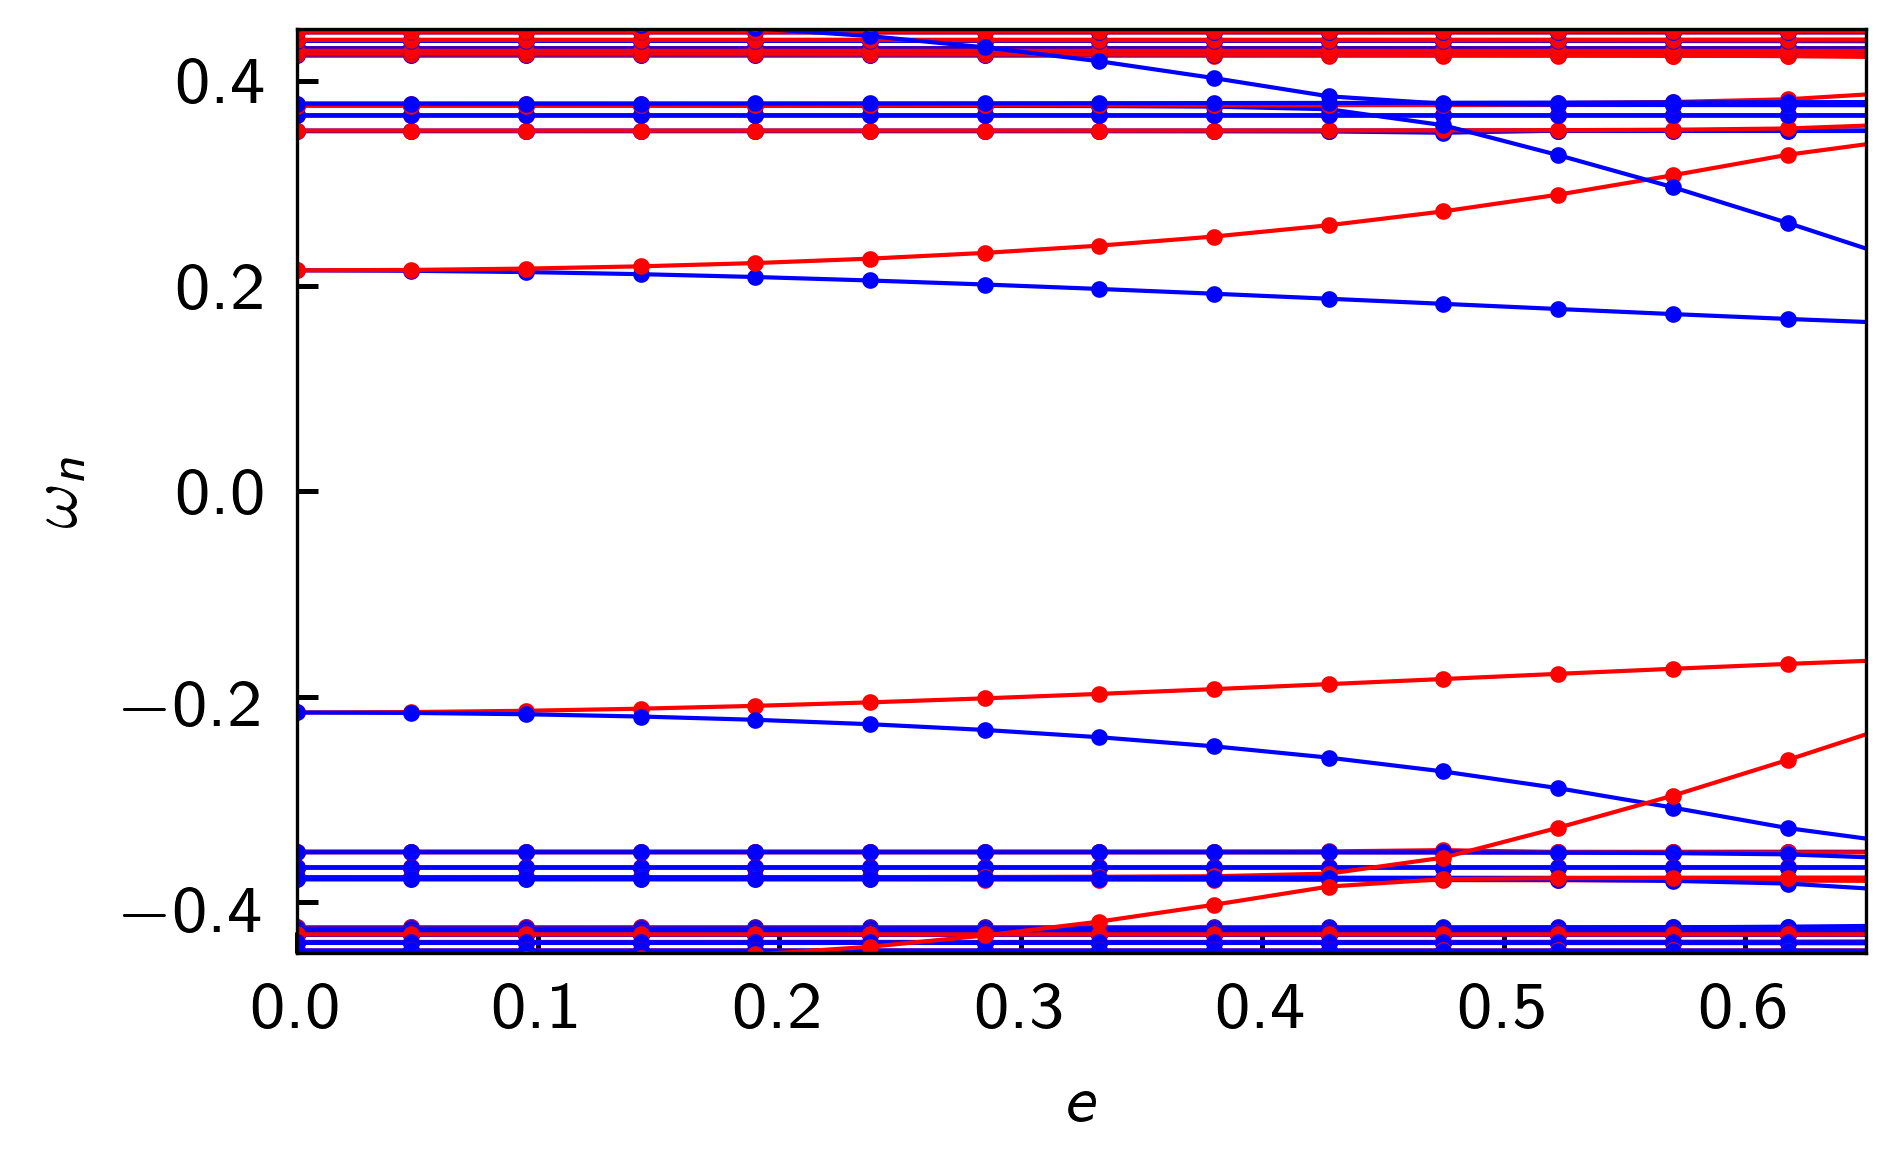

In [37]:
fig, ax = plt.subplots()#figsize=(1.3, 1.3))

for n in range(N):
    ax.plot(ecc, wss_e[:, n], ".-", color=colors[0, n])

ax.set_xlabel(r"$e$")
ax.set_ylabel(r"$\omega_n$")


ax.set_xlim(0, 0.65)
ax.set_ylim(-0.45, 0.45)

fig.savefig("./imgs/FigS2-eccentricity.svg")